# <center> Neural Net From Scratch with Numpy and Math (No PyTorch, TensorFlow etc...) on the Fashion MNIST dataset</center>
## **<center> 3 layer Neural Network with >85% Accuracy</center>**
Author: Shiven Taneja

Date: November 2023 

[GitHub Repository](https://github.com/shiven-taneja/Neural-Net-From-Scratch-with-Numpy-Fashion-MNIST-dataset) 


# 1. Overview
I have been completing the [Practical Deep Learning For Coders](https://course.fast.ai/) course by [Fast.AI](https://fast.ai). In the third lesson, we learnt the fundamentals of Neural Networks and impleneted a simple one on the MNIST digit dataset using PyTorch. I wanted to expand on this knowledge and take it a step further by only using NumPy. I also wanted to try it on a more difficult, albeit very similar dataset. As such I decided to use the Fashion MNIST dataset. 

Furthemore, I wanted to develop my understanding of the Math involved in a neural network. To learn this, I have been watching the video ["The Complete Mathematics of Neural Networks and Deep Learning"](https://youtu.be/Ixl3nykKG9M?si=qOIG4iQzROjBZsXs) By Adam Dhalla on YouTube and have been impleneting what I learnt in order to complete this neural net. I also took inspiration from the YouTube video ["Building a neural network FROM SCRATCH (no Tensorflow/Pytorch, just numpy & math)"](https://youtu.be/w8yWXqWQYmU?si=m4lDXVHJqixG0X-J) by Samsong Zhang.

# 2. Setting up the enviornment + Data Manipulation
## 2.1 Data import 

In [23]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [24]:
data = pd.read_csv('/kaggle/input/fashionmnist/fashion-mnist_train.csv')
test_data = pd.read_csv('/kaggle/input/fashionmnist/fashion-mnist_test.csv')

## 2.2 Understanding the Data 

In [25]:
data

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59996,1,0,0,0,0,0,0,0,0,0,...,73,0,0,0,0,0,0,0,0,0
59997,8,0,0,0,0,0,0,0,0,0,...,160,162,163,135,94,0,0,0,0,0
59998,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
#Turning the data to NumPy arrays and Transposing them
data = np.array(data).T
test_data = np.array(test_data).T

In [27]:
#Extracting labels from the data and normalizing image pixel values 
data_y = data[0]
data = data[1:]/255
test_data_y = test_data[0]
test_data = test_data[1:]/255

In [28]:
data_y

array([2, 9, 6, ..., 8, 8, 7])

In [29]:
print(f"Data Shape: {data.shape} \nData Labels Shape: {data_y.shape} \nTest Data Shape: {test_data.shape} \nTest Data Labels Shape: {test_data_y.shape}")

Data Shape: (784, 60000) 
Data Labels Shape: (60000,) 
Test Data Shape: (784, 10000) 
Test Data Labels Shape: (10000,)


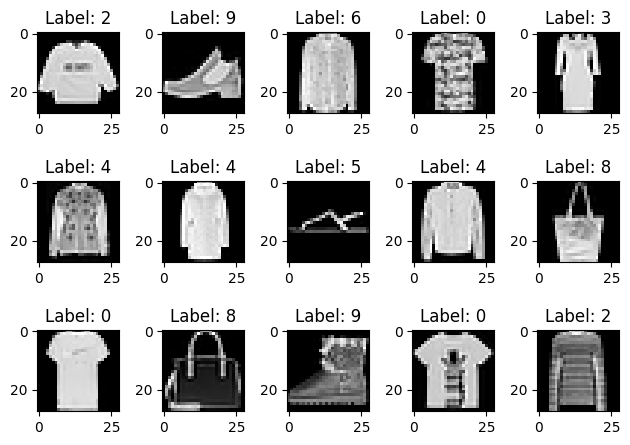

In [30]:
#Example images with label number 
for i in range(15):
    plt.subplot(3,5,i+1)
    plt.imshow(data[:, i].reshape(28,28), cmap='gray', interpolation='none')
    plt.title(f"Label: {data_y[i]}")
    plt.tight_layout()

# 3. Creating the Model and Helper Functions


## 3.1 Helper Functions

In [31]:
#Rectified Linear Unit (If any of the values of res are less than 0, they will be replaced by 0)
def ReLU(res): return np.maximum(res, 0)

In [32]:
def ReLU_derivative(x):
    return np.where(x>0, 1, 0)

In [33]:
#Activation function (Softmax) that scales the tensor into probabilities
def softmax(res):
    e_x = np.exp(res - np.max(res, axis=1, keepdims=True))
    return e_x / e_x.sum(axis=1, keepdims=True)

In [34]:
def init_params(size, std=1): return np.random.randn(*size) * std

In [35]:
#One hot encoding (Turning categorical labels into binary labels)
def one_hot(y): 
    one_h = np.zeros((y.size, y.max() + 1))
    one_h[np.arange(y.size), y] = 1
    return one_h

In [36]:
def create_batch(data, data_y, batch_size):
    batch_indexs = np.random.choice(data[0].size, batch_size, replace = False)
    xb, yb = data[:, batch_indexs], data_y[batch_indexs]
    return xb, yb

## 3.2 The Model 

The Neural Net model is created below. It has a three layer architecture where input layer $a^{[0]}$ has 784 units corresponding to the number of pixels per image ($28 \times 28$). The first hidden layer, $a^{[1]}$,will have 30 units with a ReLU activation while the second hidden layer, $a^{[2]}$, will have 10 units with a ReLU activation. Finally the ouput layer, $a^{[3]}$ will have 10 units with a softmax activation representing the 10 types of clothing in the MNIST Fashion Dataset. Huge thanks to [Mathematics behing the Neural Network](https://studymachinelearning.com/mathematics-behind-the-neural-network/) for helping me figure this out!

#### **Forward Propogation** 

$Z^{[1]} = W^{[1]}X+b^{[1]}$ \
$A^{[1]} = g_{ReLU}(Z^{[1]})$ \ 
$Z^{[2]} = W^{[2]}A^{[1]}+b^{[2]}$ \
$A^{[2]} = g_{ReLU}(Z^{[2]})$ \
$Z^{[3]} = W^{[3]}A^{[2]}+b^{[3]}$ \
$A^{[3]} = g_{softmax}(Z^{[3]})$


where: \
let $m$ = Batch Size \
$A^{[0]} = X: 784 \times m$ \
$Z^{[1]} \sim A^{[1]} = 30 \times m$ \
$W^{[1]}: 30 \times 784$ \
$B^{[1]}: 30 \times 1$ \
$Z^{[2]} \sim A^{[2]}: 10 \times m$ \
$W^{[2]}: 30 \times 10$ \
$B^{[2]}: 10 \times 1$ \
$Z^{[3]} \sim A^{[3]}: 10 \times m$ \
$W^{[3]}: 10 \times 10$ \
$B^{[3]}: 10 \times 1$ 

#### **Backward Propogation** 

**Third Layer:** 

$dZ^{[3]} = \frac{\partial L}{\partial Z^{[3]}} = \frac{\partial L}{\partial A^{[3]}} \times \frac{\partial A^{[3]}}{\partial Z^{[3]}} = A^{[3]} - Y$ \
$dW^{[3]} = \frac{\partial L}{\partial W^{[3]}} = \frac{\partial L}{\partial Z^{[3]}} \times \frac{\partial Z^{[3]}}{\partial W^{[3]}} = dZ^{[3]} \times A^{[2]}$ \
$dB^{[3]} = \frac{\partial L}{\partial B^{[3]}} = \frac{\partial L}{\partial Z^{[3]}} \times \frac{\partial Z^{[3]}}{\partial B^{[3]}} = dZ^{[3]}$

    
**Second Layer:** 

$dZ^{[2]} = \frac{\partial L}{\partial Z^{[2]}} = \frac{\partial L}{\partial A^{[2]}} \times \frac{\partial A^{[2]}}{\partial Z^{[2]}} = (dZ^{[2]} \times W^{[2]}) \times \sigma'(Z^{[2]})$ \
$dW^{[2]} = \frac{\partial L}{\partial W^{[2]}} = \frac{\partial L}{\partial Z^{[2]}} \times \frac{\partial Z^{[2]}}{\partial W^{[2]}} = dZ^{[2]} \times A^{[1]}$ \
$dB^{[2]} = \frac{\partial L}{\partial B^{[2]}} = \frac{\partial L}{\partial Z^{[2]}} \times \frac{\partial Z^{[2]}}{\partial B^{[2]}} = dZ^{[2]}$
    
**First Layer:** 

$dZ^{[1]} = \frac{\partial L}{\partial Z^{[1]}} = \frac{\partial L}{\partial A^{[1]}} \times \frac{\partial A^{[1]}}{\partial Z^{[1]}} = (dZ^{[1]} \times W^{[1]}) \times \sigma'(Z^{[1]})$ \
$dW^{[2]} = \frac{\partial L}{\partial W^{[1]}} = \frac{\partial L}{\partial Z^{[1]}} \times \frac{\partial Z^{[1]}}{\partial W^{[1]}} = dZ^{[1]} \times x$ \
$dB^{[2]} = \frac{\partial L}{\partial B^{[1]}} = \frac{\partial L}{\partial Z^{[1]}} \times \frac{\partial Z^{[1]}}{\partial B^{[1]}} = dZ^{[1]}$
    
where: \
Let m = Batch Size \
$dZ^{[3]}: 10 \times m $ \
$dW^{[3]}: 10 \times 10$ \
$dB^{[3]} = 10 \times 1$ \
$dZ^{[2]}: 10 \times m $ \
$dW^{[2]}: 10 \times 10$ \
$dB^{[2]} = 10 \times 1$ \
$dZ^{[1]}: 30 \times m $ \
$dW^{[1]}: 30 \times 10$ \
$dB^{[1]} = 30 \times 1$ 


#### **Parameter Updates** 
$W^{[3]} = W^{[3]} - \alpha \frac{\partial L}{\partial W^{[3]}} = W^{[3]} - \alpha dW^{[3]}$ \
$B^{[3]} = B^{[3]} - \alpha \frac{\partial L}{\partial B^{[3]}} = B^{[3]} - \alpha dB^{[3]}$ \
$W^{[2]} = W^{[2]} - \alpha \frac{\partial L}{\partial W^{[2]}} = W^{[2]} - \alpha dW^{[2]}$ \
$B^{[2]} = B^{[2]} - \alpha \frac{\partial L}{\partial B^{[2]}} = B^{[2]} - \alpha dB^{[2]}$ \
$W^{[1]} = W^{[1]} - \alpha \frac{\partial L}{\partial W^{[1]}} = W^{[1]} - \alpha dW^{[1]}$ \
$B^{[1]} = B^{[1]} - \alpha \frac{\partial L}{\partial B^{[1]}} = B^{[1]} - \alpha dB^{[1]}$ 

In [40]:
def create_params():
    params = {}
    params['w1'] = init_params((28*28, 30))
    params['b1'] = init_params((30,))
    params['w2'] = init_params((30,10))
    params['b2'] = init_params((10,))
    params['w3'] = init_params((10,10))
    params['b3'] = init_params((10,))
    return params

def forward(xb, params): 
    Z1 = xb.T@params['w1'] + params['b1'] 
    A1 = ReLU(Z1)
    Z2 = A1@params['w2'] + params['b2']
    A2 = ReLU(Z2)
    Z3 = A2@params['w3'] + params['b3']
    A3 = softmax(Z3)
    return A3, A2, A1

def cross_entropy_loss(res, y):
    one_hot_y = one_hot(y)
    loss = -np.sum(one_hot_y * np.log(res + 1e-6))/len(y) # Adding a small value to prevent log(0)
    return loss

def back_prop(xb, yb, res, params, l2, l1):
    grads = {}
    m = xb.shape[1]
    #Backwards pass for third layer 
    dloss_dy = res - one_hot(yb) #gradient of loss w.r.t. softmax 
    grads['w3'] = 1/m * l2.T@dloss_dy
    grads['b3'] = 1/m * np.sum(dloss_dy, axis = 0)
    
    #Backwards pass for second layer 
    d_l2 = ReLU_derivative(l2)*(dloss_dy@params['w3'].T) 
    grads['w2'] = 1/m * l1.T@d_l2
    grads['b2'] = 1/m * np.sum(d_l2, axis = 0)
    
    #Backwards pass for first layer 
    d_l1 = ReLU_derivative(l1) * (d_l2@params['w2'].T)
    grads['w1'] = 1/m * xb@d_l1
    grads['b1'] = 1/m * np.sum(d_l1, axis=0)
    
    return grads
    
def update_params(params, grads, lr):
    p = params
    for key in p.keys():
        p[key] -= lr*grads[key]
    return p
        
def accuracy(res, yb):
    return (np.argmax(res, axis=1) == yb).mean()

In [38]:
def train(data, data_y, test_data, test_data_y, epochs, batch_size = 256, lr=0.1):
    params = create_params()
    for ep in range(epochs+1): 
        for batch in range(int(data[0].size/batch_size)+1):
            #create a random batch of data 
            xb, yb = create_batch(data, data_y, batch_size)
            res, l2, l1 = forward(xb, params)
            grads = back_prop(xb, yb, res, params, l2, l1)
            params = update_params(params, grads, lr)
        if ep%50 == 0:
            res_train, l2_tr, l1_tr = forward(data, params)
            res_test, l2_t, l1_t = forward(test_data, params)
            print(f"Epoch: {ep}/{epochs}")
            print(f"Loss: {cross_entropy_loss(res_train, data_y)}")
            print(f"Training Accuracy: {accuracy(res_train, data_y)}")
            print(f"Testing Accuracy: {accuracy(res_test, test_data_y)}")
            print("----------------------------------------")

In [39]:
train(data, data_y, test_data, test_data_y, 500)

Epoch: 0/500
Loss: 2.3184859371388487
Training Accuracy: 0.10023333333333333
Testing Accuracy: 0.1003
----------------------------------------
Epoch: 50/500
Loss: 0.8115864651321977
Training Accuracy: 0.6842666666666667
Testing Accuracy: 0.6802
----------------------------------------
Epoch: 100/500
Loss: 0.5599170742393274
Training Accuracy: 0.8031166666666667
Testing Accuracy: 0.8021
----------------------------------------
Epoch: 150/500
Loss: 0.49115208093356266
Training Accuracy: 0.8246666666666667
Testing Accuracy: 0.825
----------------------------------------
Epoch: 200/500
Loss: 0.4708920073370505
Training Accuracy: 0.8317833333333333
Testing Accuracy: 0.8306
----------------------------------------
Epoch: 250/500
Loss: 0.4475513396682349
Training Accuracy: 0.8415333333333334
Testing Accuracy: 0.8363
----------------------------------------
Epoch: 300/500
Loss: 0.4250164356682839
Training Accuracy: 0.85055
Testing Accuracy: 0.8447
----------------------------------------
Epoch